# Setup

Research Question: Can a model learn to classify hidden categories? Does imposing order on the response variable improve the model's ability to classify hidden categories?



In [ ]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import PIL
import itertools
import shutil
import random
import glob
import warnings

import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Definition
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

In [ ]:
# Category Sizes
noDementia = 3200
veryMildDementia = 2240
mildDementia = 896
moderateDementia = 64
total = noDementia + veryMildDementia + mildDementia + moderateDementia

### Data Loading

In [ ]:
# Split train dataset into train and vaild
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/train/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/train/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

train_ds_cat = train_ds # for categorical processing
train_ds_reg = train_ds
val_ds_cat = val_ds # for regression processing
val_ds_reg = val_ds
train_ds_reg_xcept = train_ds # for xception processing
val_ds_reg_xcept = val_ds

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds_cat.class_names = class_names
val_ds_cat.class_names = class_names

NUM_CLASSES = len(class_names)

### Visualize the data

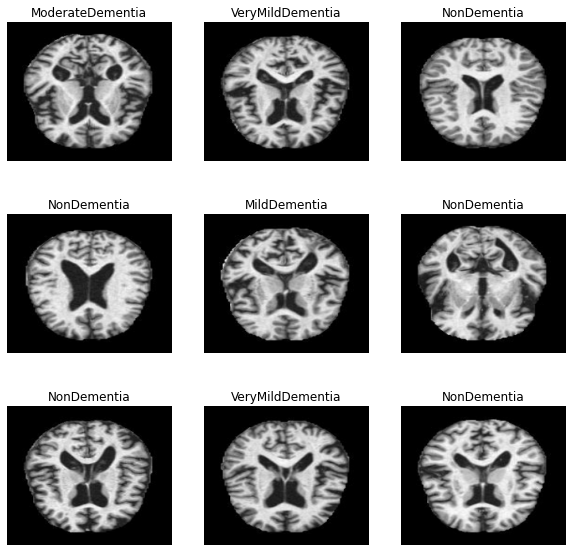

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_cat.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds_cat.class_names[labels[i]])
    plt.axis("off")

# Categorical Model

### Feature Engineering

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds_cat = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds_cat = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

### Deciding a Metric

In [ ]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

NUM_IMAGES

[717, 52, 2560, 1792]

### Build Model


In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [ ]:
# using the TPU, compile model
with strategy.scope():
    categorical_model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')] #,tf.keras.metrics.Accuracy
    
    categorical_model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

### Train Model


In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_categorical_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history1 = categorical_model.fit(
    train_ds_cat,
    validation_data=val_ds_cat,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
257/257 [==============================] - 18s 65ms/step - loss: 1.3326 - auc: 0.7192 - val_loss: 13.6490 - val_auc: 0.6634
Epoch 2/100
257/257 [==============================] - 16s 64ms/step - loss: 1.0190 - auc: 0.7958 - val_loss: 58.3885 - val_auc: 0.6647
Epoch 3/100
257/257 [==============================] - 16s 64ms/step - loss: 0.9899 - auc: 0.8041 - val_loss: 19.5972 - val_auc: 0.6653
Epoch 4/100
257/257 [==============================] - 16s 63ms/step - loss: 0.9628 - auc: 0.8135 - val_loss: 0.9868 - val_auc: 0.8004
Epoch 5/100
257/257 [==============================] - 16s 63ms/step - loss: 0.9534 - auc: 0.8184 - val_loss: 1.1612 - val_auc: 0.6782
Epoch 6/100
257/257 [==============================] - 16s 63ms/step - loss: 0.9430 - auc: 0.8232 - val_loss: 1.1572 - val_auc: 0.8161
Epoch 7/100
257/257 [==============================] - 16s 63ms/step - loss: 0.9221 - auc: 0.8327 - val_loss: 2.0927 - val_auc: 0.7853
Epoch 8/100
257/257 [==============================]

### Visualize Metrics

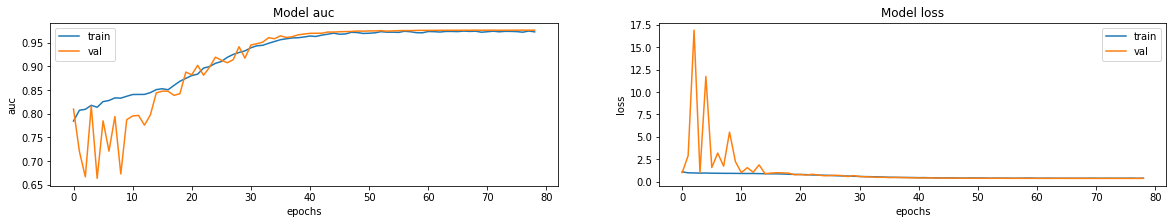

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Evaluate Model

In [ ]:
test_ds_cat = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds_cat = test_ds_cat.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds_cat = test_ds_cat.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
categorical_performance = categorical_model.evaluate(test_ds_cat)

80/80 [==============================] - 3s 33ms/step - loss: 0.9580 - auc: 0.8159


In [ ]:
categorical_predictions = categorical_model.predict(test_ds_cat)
categorical_predictions = np.argmax(categorical_predictions, axis=1)

In [ ]:
test_ds_cat_true = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=1279,
)
class_nums = [2, 3, 0, 1]
test_ds_cat_true.class_nums = class_nums
test_ds_cat_true

Found 1279 files belonging to 4 classes.


<BatchDataset shapes: ((None, 176, 208, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def label_map(image, label):
    return image, label

test_ds_cat_labels = np.array([y for x, y in test_ds_cat_true]).reshape(1279,)
# test_ds_reg_labels = np.concatenate([y for x, y in test_ds_reg_true], axis=0)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_ds_cat_labels, categorical_predictions)

0.47537138389366695

# Continuous Regression

## Feature Engineering

In [ ]:
class_names = [2.5, 3.5, 0.5, 1.5]
train_ds_reg.class_names = class_names
val_ds_reg.class_names = class_names

In [ ]:
def continuity_map(image, label):
    return image, label

train_ds_reg = train_ds_reg.map(continuity_map, num_parallel_calls=AUTOTUNE)
val_ds_reg = val_ds_reg.map(continuity_map, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds_reg = train_ds_reg.map(continuity_map, num_parallel_calls=AUTOTUNE)
val_ds_reg = val_ds_reg.map(continuity_map, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds_reg = train_ds_reg.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_reg = val_ds_reg.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
val_ds_cat


<PrefetchDataset shapes: ((None, 176, 208, 3), (None, 4)), types: (tf.float32, tf.float32)>

## Build Model

In [ ]:
def build_regression_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1)
    ])
    
    return model

In [ ]:
# using the TPU, compile model
with strategy.scope():
    regression_model = build_regression_model()

    METRICS = [tf.keras.metrics.MeanAbsoluteError()]
    
    regression_model.compile(
        optimizer='adam',
        loss=tf.losses.MeanSquaredError(),
        metrics=METRICS
    )

## Train Model

In [ ]:
exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_continuous_regression_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history_reg = regression_model.fit(
    train_ds_reg,
    validation_data=val_ds_reg,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs= EPOCHS
)

Epoch 1/100
257/257 [==============================] - 18s 64ms/step - loss: 2.3396 - mean_absolute_error: 1.1608 - val_loss: 0.9663 - val_mean_absolute_error: 0.7091
Epoch 2/100
257/257 [==============================] - 16s 63ms/step - loss: 1.0575 - mean_absolute_error: 0.7779 - val_loss: 1.5252 - val_mean_absolute_error: 1.1425
Epoch 3/100
257/257 [==============================] - 16s 63ms/step - loss: 0.9952 - mean_absolute_error: 0.7450 - val_loss: 0.9450 - val_mean_absolute_error: 0.6649
Epoch 4/100
257/257 [==============================] - 16s 63ms/step - loss: 0.9575 - mean_absolute_error: 0.7220 - val_loss: 1.0805 - val_mean_absolute_error: 0.8489
Epoch 5/100
257/257 [==============================] - 16s 62ms/step - loss: 0.9592 - mean_absolute_error: 0.7143 - val_loss: 3.5728 - val_mean_absolute_error: 1.7377
Epoch 6/100
257/257 [==============================] - 16s 63ms/step - loss: 0.9357 - mean_absolute_error: 0.7091 - val_loss: 2.1146 - val_mean_absolute_error: 1.359

## Visualize Metrics

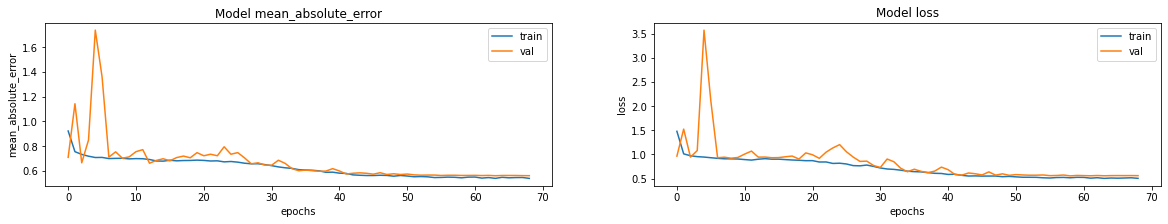

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['mean_absolute_error', 'loss']):
    ax[i].plot(history_reg.history[met])
    ax[i].plot(history_reg.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Evaluate Model

In [ ]:
test_ds_reg = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

class_nums = [2, 3, 0, 1]
test_ds_reg.class_nums = class_nums

Found 1279 files belonging to 4 classes.


In [ ]:
Regression_performance = regression_model.evaluate(test_ds_reg)

80/80 [==============================] - 3s 39ms/step - loss: 0.8388 - mean_absolute_error: 0.6556


In [ ]:
regression_predictions = regression_model.predict(test_ds_reg)

In [ ]:
regression_predictions.shape

(1279, 1)

In [ ]:
rounded_regression_predictions = [abs(round(regression_predictions[i][0]-0.5)) for i in range(len(regression_predictions))]

In [ ]:
test_ds_reg_true = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=1279,
)
class_nums = [2, 3, 0, 1]
test_ds_reg_true.class_nums = class_nums
test_ds_reg_true

Found 1279 files belonging to 4 classes.


<BatchDataset shapes: ((None, 176, 208, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def label_map(image, label):
    return image, label

test_ds_reg_labels = np.array([y for x, y in test_ds_reg_true]).reshape(1279,)
# test_ds_reg_labels = np.concatenate([y for x, y in test_ds_reg_true], axis=0)

In [ ]:
import collections
collections.Counter(test_ds_reg_labels)

Counter({0: 179, 1: 12, 2: 640, 3: 448})

In [ ]:
collections.Counter(rounded_regression_predictions)

Counter({0: 41, 1: 246, 2: 990, 3: 2})

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy_score(test_ds_reg_labels, rounded_regression_predictions)
# roc_auc_score(test_ds_reg_labels, rounded_regression_predictions, multi_class='ovo', labels=[0,1,2,3])

0.3971853010164191

# Discrete Regression

## Build Model

In [ ]:
def build_discrete_regression_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1),

        tf.keras.layers.Dense(10 activation='relu')

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax') # can we hard code the bias weights so that the thresholds
    ])
    
    return model

SyntaxError: ignored

In [ ]:
# using the TPU, compile model
with strategy.scope():
    discrete_regression_model = build_discrete_regression_model()

    METRICS = [tf.keras.metrics.MeanAbsoluteError()]
    
    discrete_regression_model.compile(
        optimizer='adam',
        loss=tf.losses.MeanSquaredError(),
        metrics=METRICS
    )

## Train Model

In [ ]:
exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_discrete_regression_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history_reg = discrete_regression_model.fit(
    train_ds_reg,
    validation_data=val_ds_reg,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs= EPOCHS
)

Epoch 1/100
257/257 [==============================] - 18s 63ms/step - loss: 4.2350 - mean_absolute_error: 1.8889 - val_loss: 4.1670 - val_mean_absolute_error: 1.8687
Epoch 2/100
257/257 [==============================] - 16s 63ms/step - loss: 4.2300 - mean_absolute_error: 1.8889 - val_loss: 4.1670 - val_mean_absolute_error: 1.8687
Epoch 3/100
257/257 [==============================] - 16s 63ms/step - loss: 4.2300 - mean_absolute_error: 1.8889 - val_loss: 4.1670 - val_mean_absolute_error: 1.8687
Epoch 4/100
257/257 [==============================] - 16s 62ms/step - loss: 4.2300 - mean_absolute_error: 1.8889 - val_loss: 4.1670 - val_mean_absolute_error: 1.8687
Epoch 5/100
257/257 [==============================] - 16s 62ms/step - loss: 4.2300 - mean_absolute_error: 1.8889 - val_loss: 4.1670 - val_mean_absolute_error: 1.8687
Epoch 6/100
257/257 [==============================] - 16s 62ms/step - loss: 4.2300 - mean_absolute_error: 1.8889 - val_loss: 4.1670 - val_mean_absolute_error: 1.868

## Visualize Metrics

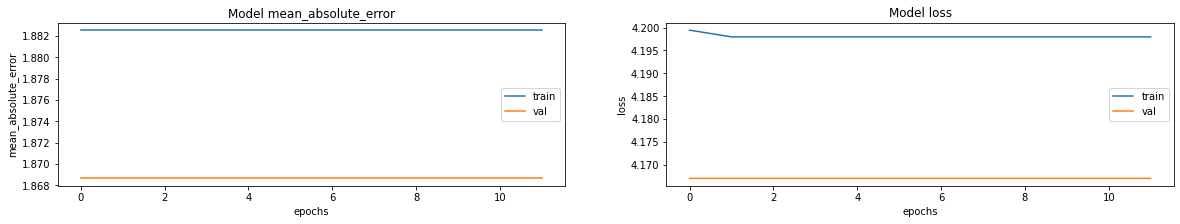

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['mean_absolute_error', 'loss']):
    ax[i].plot(history_reg.history[met])
    ax[i].plot(history_reg.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Evaluate Model

In [ ]:
test_ds_reg = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

class_nums = [2.5, 3.5, 0.5, 1.5]
test_ds_reg.class_nums = class_nums

Found 1279 files belonging to 4 classes.


In [ ]:
Regression_performance = discrete_regression_model.evaluate(test_ds_reg)

80/80 [==============================] - 3s 38ms/step - loss: 4.1954 - mean_absolute_error: 1.8810


In [ ]:
regression_predictions = discrete_regression_model.predict(test_ds_reg)

In [ ]:
regression_predictions.shape

(1279, 4)

In [ ]:
rounded_regression_predictions = [abs(round(regression_predictions[i][0]-0.5)) for i in range(len(regression_predictions))]

In [ ]:
test_ds_reg_true = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
class_nums = [2, 3, 0, 1]
test_ds_reg_true.class_nums = class_nums
test_ds_reg_true

Found 1279 files belonging to 4 classes.


<BatchDataset shapes: ((None, 176, 208, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def label_map(image, label):
    return image, label

test_ds_reg_labels = np.concatenate([y for x, y in test_ds_reg_true], axis=0)

In [ ]:
test_ds_reg_labels

array([2, 3, 1, ..., 2, 3, 2], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_ds_reg_labels, rounded_regression_predictions)

0.13995308835027365

# Xception Categorical

## Feature Engineering

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds_xcept = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds_xcept = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds_xcept = train_ds_xcept.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_xcept = val_ds_xcept.cache().prefetch(buffer_size=AUTOTUNE)

## Deciding a Metric

In [ ]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

NUM_IMAGES

[717, 52, 2560, 1792]

## Build and Freeze Model

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(NUM_CLASSES, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# for index, layer in enumerate(base_model.layers):
    # print(index, layer.name)

In [ ]:
## Freeze the weights of the layers from the pretrained model
for layer in base_model.layers:
    layer.trainable = False

METRICS = [tf.keras.metrics.AUC(name='auc')] 

model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

### Train Model

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("freeze_cat_xception_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds_xcept,
    validation_data=val_ds_xcept,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
257/257 [==============================] - 1582s 6s/step - loss: 3.7658 - auc: 0.7327 - val_loss: 2.2526 - val_auc: 0.7800
Epoch 2/100
257/257 [==============================] - 16s 63ms/step - loss: 2.0945 - auc: 0.8059 - val_loss: 2.8662 - val_auc: 0.7587
Epoch 3/100
257/257 [==============================] - 16s 63ms/step - loss: 2.0406 - auc: 0.8140 - val_loss: 2.1999 - val_auc: 0.7885
Epoch 4/100
257/257 [==============================] - 16s 61ms/step - loss: 1.5703 - auc: 0.8428 - val_loss: 2.0266 - val_auc: 0.8145
Epoch 5/100
257/257 [==============================] - 16s 61ms/step - loss: 1.5466 - auc: 0.8499 - val_loss: 1.5843 - val_auc: 0.8456
Epoch 6/100
257/257 [==============================] - 16s 61ms/step - loss: 1.0821 - auc: 0.8810 - val_loss: 1.6333 - val_auc: 0.8378
Epoch 7/100
257/257 [==============================] - 16s 62ms/step - loss: 1.0308 - auc: 0.8856 - val_loss: 2.3638 - val_auc: 0.7818
Epoch 8/100
257/257 [==============================] - 

### Visualize Metrics

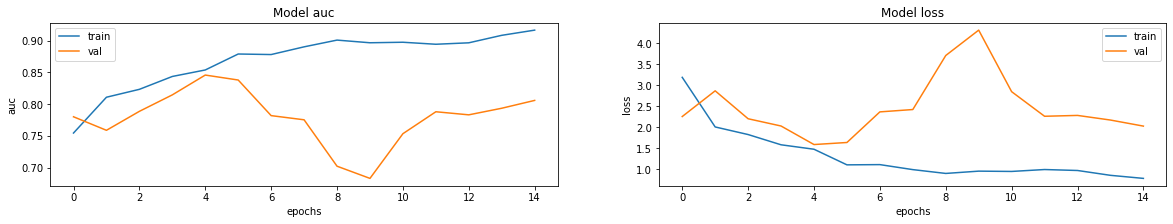

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Evaluate Model

In [ ]:
test_ds_xcept = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds_xcept = test_ds_xcept.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds_xcept = test_ds_xcept.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
xception_performance = model.evaluate(test_ds_xcept)

80/80 [==============================] - 430s 5s/step - loss: 6.3337 - auc: 0.7624


In [ ]:
xception_predictions = model.predict(test_ds_xcept)
xception_predictions = np.argmax(xception_predictions, axis=1)

In [ ]:
test_ds_xcept_true = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=1279,
)
class_nums = [2, 3, 0, 1]
test_ds_xcept_true.class_nums = class_nums
test_ds_xcept_true

Found 1279 files belonging to 4 classes.


<BatchDataset shapes: ((None, 176, 208, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def label_map(image, label):
    return image, label

test_ds_xcept_labels = np.array([y for x, y in test_ds_xcept_true]).reshape(1279,)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_ds_xcept_labels, xception_predictions)

0.3846755277560594

## Build and Unfreeze Model

In [ ]:
# Now, unfreeze and use much smaller learning rate
for layer in base_model.layers:
    layer.trainable = True

METRICS = [tf.keras.metrics.AUC(name='auc')]

model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

### Train Model

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("unfreeze_cat_xception_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds_xcept,
    validation_data=val_ds_xcept,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
257/257 [==============================] - 67s 241ms/step - loss: 1.4723 - auc: 0.7961 - val_loss: 41.7928 - val_auc: 0.5671
Epoch 2/100
257/257 [==============================] - 61s 239ms/step - loss: 0.8393 - auc: 0.8616 - val_loss: 2.3182 - val_auc: 0.8173
Epoch 3/100
257/257 [==============================] - 60s 235ms/step - loss: 0.6837 - auc: 0.9114 - val_loss: 6.8337 - val_auc: 0.6129
Epoch 4/100
257/257 [==============================] - 61s 236ms/step - loss: 0.5412 - auc: 0.9451 - val_loss: 5.2285 - val_auc: 0.7220
Epoch 5/100
257/257 [==============================] - 61s 236ms/step - loss: 0.3956 - auc: 0.9709 - val_loss: 17.9846 - val_auc: 0.6634
Epoch 6/100
257/257 [==============================] - 62s 243ms/step - loss: 0.2610 - auc: 0.9865 - val_loss: 0.8691 - val_auc: 0.9389
Epoch 7/100
257/257 [==============================] - 61s 238ms/step - loss: 0.2001 - auc: 0.9921 - val_loss: 1.4667 - val_auc: 0.9109
Epoch 8/100
257/257 [=========================

### Visualize Metrics

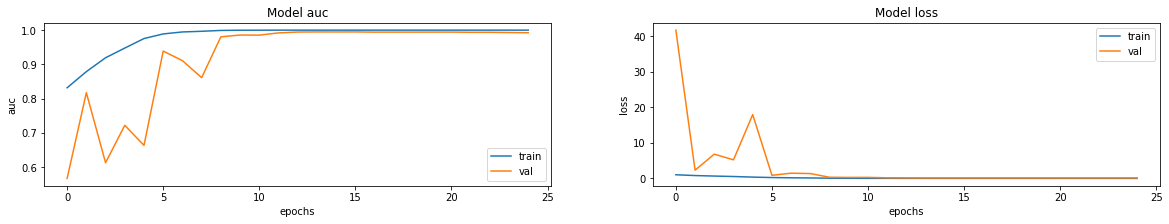

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Evaluate Model

In [ ]:
test_ds_xcept = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds_xcept = test_ds_xcept.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds_xcept = test_ds_xcept.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
xception_performance = model.evaluate(test_ds_xcept)

80/80 [==============================] - 4s 53ms/step - loss: 2.0604 - auc: 0.8426


In [ ]:
xception_predictions = model.predict(test_ds_xcept)
xception_predictions = np.argmax(xception_predictions, axis=1)

In [ ]:
test_ds_xcept_true = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=1279,
)
class_nums = [2, 3, 0, 1]
test_ds_xcept_true.class_nums = class_nums
test_ds_xcept_true

Found 1279 files belonging to 4 classes.


<BatchDataset shapes: ((None, 176, 208, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def label_map(image, label):
    return image, label

test_ds_xcept_labels = np.array([y for x, y in test_ds_xcept_true]).reshape(1279,)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_ds_xcept_labels, xception_predictions)

0.42376856919468336

# Xception Regression

## Feature Engineering

In [ ]:
class_names = [2.5, 3.5, 0.5, 1.5]
train_ds_reg_xcept.class_names = class_names
val_ds_reg_xcept.class_names = class_names

In [ ]:
def continuity_map(image, label):
    return image, label

train_ds_reg_xcept = train_ds_reg_xcept.map(continuity_map, num_parallel_calls=AUTOTUNE)
val_ds_reg_xcept = val_ds_reg_xcept.map(continuity_map, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds_reg_xcept = train_ds_reg_xcept.map(continuity_map, num_parallel_calls=AUTOTUNE)
val_ds_reg_xcept = val_ds_reg_xcept.map(continuity_map, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds_reg_xcept = train_ds_reg_xcept.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_reg_xcept = val_ds_reg_xcept.cache().prefetch(buffer_size=AUTOTUNE)

##Build and Freeze Model

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="relu")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
## Freeze the weights of the layers from the pretrained model
for layer in base_model.layers:
    layer.trainable = False

METRICS = [tf.keras.metrics.MeanAbsoluteError()]

model.compile(
        optimizer='adam',
        loss=tf.losses.MeanSquaredError(),
        metrics=METRICS
    )

### Train Model

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("freeze_reg_xception_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds_reg_xcept,
    validation_data=val_ds_reg_xcept,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
257/257 [==============================] - 19s 64ms/step - loss: 6.4926 - mean_absolute_error: 2.1606 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 2/100
257/257 [==============================] - 16s 63ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 3/100
257/257 [==============================] - 16s 61ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 4/100
257/257 [==============================] - 15s 60ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 5/100
257/257 [==============================] - 15s 60ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 6/100
257/257 [==============================] - 16s 60ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.044

### Visualize Metrics

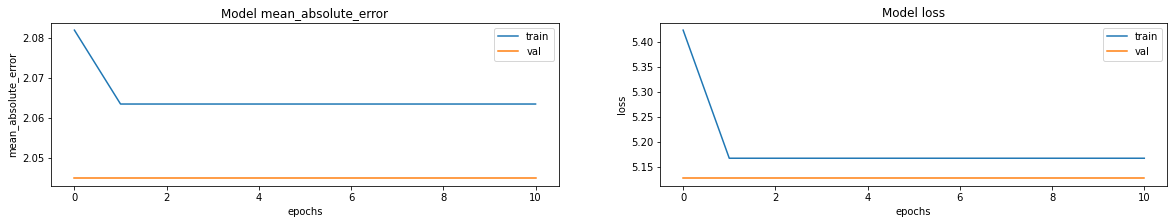

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['mean_absolute_error', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Evaluate Model

In [ ]:
test_ds_reg_xcept = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds_reg_xcept = test_ds_reg_xcept.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds_reg_xcept = test_ds_reg_xcept.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
xception_performance = model.evaluate(test_ds_reg_xcept)

80/80 [==============================] - 7s 66ms/step - loss: 0.2500 - mean_absolute_error: 0.2500


In [ ]:
xception_predictions = model.predict(test_ds_reg_xcept)
xception_predictions = np.argmax(xception_predictions, axis=1)

In [ ]:
test_ds_reg_xcept_true = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=1279,
)
class_nums = [2, 3, 0, 1]
test_ds_reg_xcept_true.class_nums = class_nums
test_ds_reg_xcept_true

Found 1279 files belonging to 4 classes.


<BatchDataset shapes: ((None, 176, 208, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def label_map(image, label):
    return image, label

test_ds_reg_xcept_labels = np.array([y for x, y in test_ds_reg_xcept_true]).reshape(1279,)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_ds_reg_xcept_labels, xception_predictions)

0.13995308835027365

## Build and Unfreeze Model

In [ ]:
# Now, unfreeze and use much smaller learning rate
for layer in base_model.layers:
    layer.trainable = True

METRICS = [tf.keras.metrics.MeanAbsoluteError()]

model.compile(
        optimizer='adam',
        loss=tf.losses.MeanSquaredError(),
        metrics=METRICS
    )

### Train Model

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("unfreeze_reg_xception_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds_reg_xcept,
    validation_data=val_ds_reg_xcept,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
257/257 [==============================] - 62s 228ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 2/100
257/257 [==============================] - 57s 223ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 3/100
257/257 [==============================] - 57s 223ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 4/100
257/257 [==============================] - 57s 223ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 5/100
257/257 [==============================] - 57s 223ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error: 2.0449
Epoch 6/100
257/257 [==============================] - 57s 223ms/step - loss: 5.1905 - mean_absolute_error: 2.0672 - val_loss: 5.1270 - val_mean_absolute_error:

### Visualize Metrics

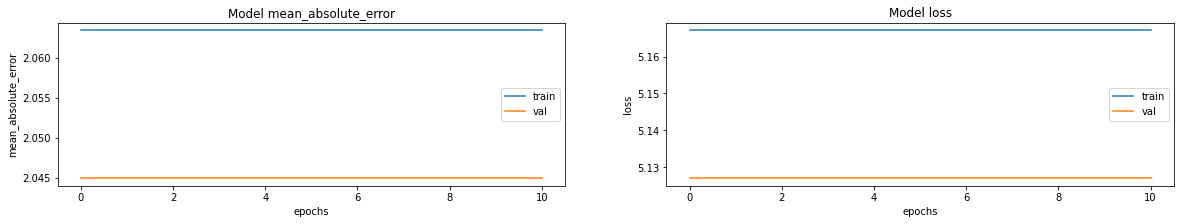

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['mean_absolute_error', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Evaluate Model

In [ ]:
test_ds_reg_xcept = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds_reg_xcept = test_ds_reg_xcept.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds_reg_xcept = test_ds_reg_xcept.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
xception_performance = model.evaluate(test_ds_reg_xcept)

80/80 [==============================] - 5s 50ms/step - loss: 0.2500 - mean_absolute_error: 0.2500


In [ ]:
xception_predictions = model.predict(test_ds_reg_xcept)
xception_predictions = np.argmax(xception_predictions, axis=1)

In [ ]:
test_ds_reg_xcept_true = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/725-mini-project/Original_Alzheimer_Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=1279,
)
class_nums = [2, 3, 0, 1]
test_ds_reg_xcept_true.class_nums = class_nums
test_ds_reg_xcept_true

Found 1279 files belonging to 4 classes.


<BatchDataset shapes: ((None, 176, 208, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def label_map(image, label):
    return image, label

test_ds_reg_xcept_labels = np.array([y for x, y in test_ds_reg_xcept_true]).reshape(1279,)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_ds_reg_xcept_labels, xception_predictions)

0.13995308835027365